In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [84]:
df = pd.read_csv('/content/qa-data-eng-analysis.csv')

In [85]:
print(df.dtypes)

News-Source           object
Has-Nightmare         object
News-Preference       object
News-Trust            object
Emotional-Response    object
Shares-News           object
Dwelling-On-News      object
Fear-Reaction         object
dtype: object


## Relationship Between Dwelling-On-News and Has-Nightmare

In [86]:
# Clean relevant columns
df_clean = df[
    (df['Dwelling-On-News'].isin(['Thinking', 'OverThink', 'NoThinking'])) &
    (df['Has-Nightmare'].isin(['Yes', 'No']))
].copy()

# %% Create Contingency Table
contingency_table = pd.crosstab(
    df_clean['Dwelling-On-News'],
    df_clean['Has-Nightmare']
)

# Reorder categories for logical display
contingency_table = contingency_table.reindex(['NoThinking', 'Thinking', 'OverThink'])

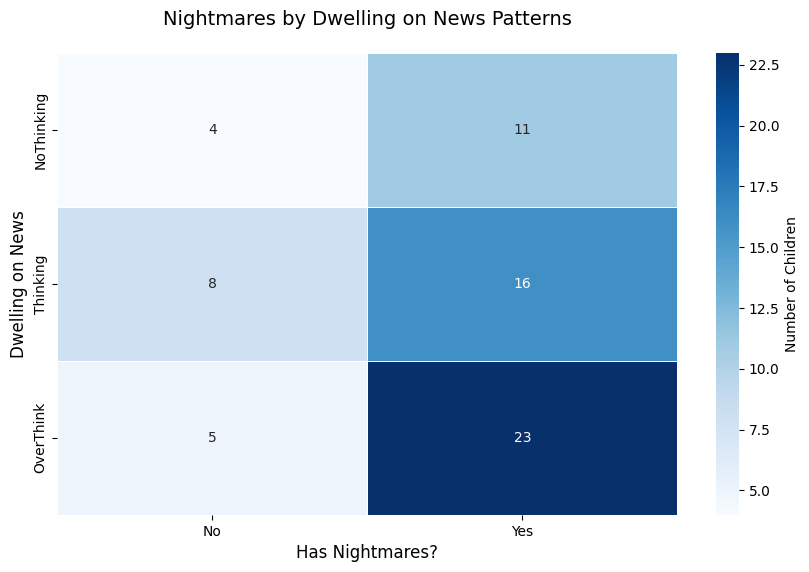

In [87]:
plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    contingency_table,
    annot=True,
    fmt="d",
    cmap="Blues",
    linewidths=0.5,
    cbar_kws={'label': 'Number of Children'}
)

ax.set_xlabel("Has Nightmares?", fontsize=12)
ax.set_ylabel("Dwelling on News", fontsize=12)
ax.set_title("Nightmares by Dwelling on News Patterns", pad=20, fontsize=14)
plt.show()

## Relationship Between Emotional Response and Fear Reaction

In [89]:
df_clean = df[df["Fear-Reaction"] != "UnKown"]  # Remove unknown coping mechanisms
df_clean = df[df["Emotional-Response"] != "UnKown"]  # Remove unknown emotions

coping_emotion = (
    df.groupby("Fear-Reaction")["Emotional-Response"]
    .value_counts(normalize=True)  # Get proportions
    .mul(100)  # Convert to percentages
    .unstack(fill_value=0)  # Reshape into a matrix
    .round(1)  # Round to 1 decimal place
)

print("Emotional Response Distribution by Coping Mechanism (%):")
print(coping_emotion)

Emotional Response Distribution by Coping Mechanism (%):
Emotional-Response   Little Fear  Normal   Sad  Very Fear
Fear-Reaction                                            
Nothing                     22.2    16.7  16.7       44.4
Sharing Immediately         41.7     8.3   8.3       41.7
Talking with Dad            15.4    34.6  23.1       26.9
Trying To Forget            36.8    26.3  10.5       26.3


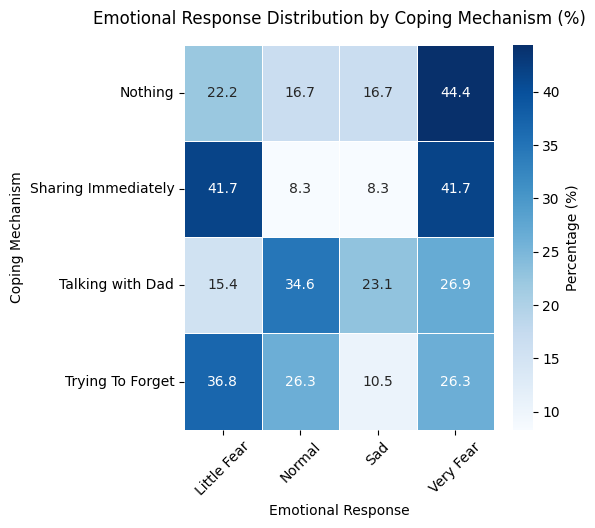

In [95]:
plt.figure(figsize=(5, 5))
sns.heatmap(
    coping_emotion,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    linewidths=0.5,
    cbar_kws={'label': 'Percentage (%)'}
)
plt.title("Emotional Response Distribution by Coping Mechanism (%)", pad=15)
plt.xlabel("Emotional Response")
plt.ylabel("Coping Mechanism")
plt.xticks(rotation=45)
plt.show()

## PreProcessing

In [127]:
def apply_encoding(df):
    # Fix 1: Correct typo 'Unkown' -> 'UnKown'
    df = df.replace({'UnKown': np.nan})
    # Binary columns (handle 'Yes'/'No')
    binary_cols = ['News-Preference', 'News-Trust', 'Shares-News', 'Has-Nightmare']
    binary_map = {'Yes': 1, 'No': 0}
    df[binary_cols] = df[binary_cols].replace(binary_map)

    # Fix 3: Include 'Normal' in emotional_response_map
    emotional_response_map = {
        'Normal': 0,  # Added
        'Sad': 1,
        'Little Fear': 2,
        'Very Fear': 3
    }

    # Ordinal mappings
    dwelling_on_news = {'NoThinking': 1, 'Thinking': 2, 'OverThink': 3}

    # Map and fill NaN with mode (after including 'Normal')
    df['Emotional-Response'] = (
        df['Emotional-Response']
        .map(emotional_response_map)
        .fillna(df['Emotional-Response'].mode()[0])
    )

    df['Dwelling-On-News'] = (
        df['Dwelling-On-News']
        .map(dwelling_on_news)
        .fillna(df['Dwelling-On-News'].mode()[0])
    )

    # One-hot encoding (drop_first=True to avoid multicollinearity)
    news_source_dummies = pd.get_dummies(
        df['News-Source'],
        prefix='NewsSource',
        dummy_na=False     # Don't create NaN dummies (already handled)
    ).astype(int)

    fear_reaction_dummies = pd.get_dummies(
        df['Fear-Reaction'],
        prefix='FearReaction',
        dummy_na=False
    ).astype(int)

    # Impute NaN with mode for binary columns
    for col in binary_cols:
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)

    # Create a copy of the original categorical columns before dropping
    df_with_cats = df.copy()

    df = df.drop(['News-Source', 'Fear-Reaction'], axis=1)
    encoded_df = pd.concat([df, news_source_dummies, fear_reaction_dummies], axis=1)

    return encoded_df, df_with_cats

## Dwelling-On-News Analysis (useless)

In [128]:
df = pd.read_csv('/content/qa-data-eng-analysis.csv')

In [133]:
!pip install ctgan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
  

In [134]:
from ctgan import CTGAN

def generate_synthetic_data(filepath, num_samples=500, epochs=100):
    # Load the original dataset
    real_data = pd.read_csv(filepath)

    # Identify discrete (categorical) columns
    discrete_columns = real_data.columns.tolist()  # All columns are categorical

    # Train CTGAN
    ctgan = CTGAN(
        epochs=epochs,  # Increase epochs for better fidelity
        verbose=True
    )
    ctgan.fit(real_data, discrete_columns)

    # Generate synthetic data
    synthetic_data = ctgan.sample(num_samples)

    return synthetic_data

# Generate synthetic data
df = generate_synthetic_data("/content/qa-data-eng-analysis.csv", num_samples=200)

Gen. (0.91) | Discrim. (0.02): 100%|██████████| 100/100 [00:08<00:00, 12.05it/s]


In [135]:
encoded_df, df_with_cats = apply_encoding(df)

In [136]:
# Create a reverse mapping for better readability in tables
dwelling_reverse_map = {1: 'NoThinking', 2: 'Thinking', 3: 'OverThink'}
emotional_reverse_map = {0: 'Normal', 1: 'Sad', 2: 'Little Fear', 3: 'Very Fear'}

In [137]:
# ---- 1. News-Source × Emotional-Response × Dwelling-On-News ----
# Create a cross-tabulation
news_emotion_dwelling = pd.crosstab(
    [df_with_cats['News-Source'], df_with_cats['Emotional-Response']],
    df_with_cats['Dwelling-On-News'],
    normalize='index'  # Shows percentages by row
).round(2) * 100  # Convert to percentages

# Create a more readable version with the original categories
news_emotion_dwelling.columns = [dwelling_reverse_map[col] for col in news_emotion_dwelling.columns]

# ---- 2. Has-Nightmare × News-Trust × Dwelling-On-News ----
nightmare_trust_dwelling = pd.crosstab(
    [df_with_cats['Has-Nightmare'], df_with_cats['News-Trust']],
    df_with_cats['Dwelling-On-News'],
    normalize='index'
).round(2) * 100

nightmare_trust_dwelling.columns = [dwelling_reverse_map[col] for col in nightmare_trust_dwelling.columns]

# ---- 3. Fear-Reaction × Emotional-Response × Dwelling-On-News ----
fear_emotion_dwelling = pd.crosstab(
    [df_with_cats['Fear-Reaction'], df_with_cats['Emotional-Response']],
    df_with_cats['Dwelling-On-News'],
    normalize='index'
).round(2) * 100

fear_emotion_dwelling.columns = [dwelling_reverse_map[col] for col in fear_emotion_dwelling.columns]

# Statistical significance testing
# Example for News-Source × Dwelling-On-News
news_dwelling_table = pd.crosstab(df_with_cats['News-Source'], df_with_cats['Dwelling-On-News'])
chi2, p, dof, expected = chi2_contingency(news_dwelling_table)
news_dwelling_significance = {"chi2": round(chi2, 2), "p-value": round(p, 4), "dof": dof}

# Example for Emotional-Response × Dwelling-On-News
emotion_dwelling_table = pd.crosstab(df_with_cats['Emotional-Response'], df_with_cats['Dwelling-On-News'])
chi2, p, dof, expected = chi2_contingency(emotion_dwelling_table)
emotion_dwelling_significance = {"chi2": round(chi2, 2), "p-value": round(p, 4), "dof": dof}

# Create visualizations
def create_heatmap(table, title):
    plt.figure(figsize=(10, 6))
    sns.heatmap(table, annot=True, cmap="YlGnBu", fmt='.0f')
    plt.title(title)
    plt.tight_layout()
    return plt

# Function to get the most common overthinking level for combinations
def find_most_common_overthinking(crosstab):
    max_values = crosstab.idxmax(axis=1)
    return max_values

# Find which combinations lead to higher overthinking
news_emotion_overthinking = find_most_common_overthinking(news_emotion_dwelling)
nightmare_trust_overthinking = find_most_common_overthinking(nightmare_trust_dwelling)
fear_emotion_overthinking = find_most_common_overthinking(fear_emotion_dwelling)

# Results summary
results = {
    'news_emotion_dwelling': news_emotion_dwelling,
    'nightmare_trust_dwelling': nightmare_trust_dwelling,
    'fear_emotion_dwelling': fear_emotion_dwelling,
    'news_source_significance': news_dwelling_significance,
    'emotional_response_significance': emotion_dwelling_significance,
    'high_overthinking_combinations': {
        'news_emotion': news_emotion_overthinking[news_emotion_overthinking == 'OverThink'],
        'nightmare_trust': nightmare_trust_overthinking[nightmare_trust_overthinking == 'OverThink'],
        'fear_emotion': fear_emotion_overthinking[fear_emotion_overthinking == 'OverThink']
    }
}

# Display the results
print("News Source × Emotional Response × Dwelling On News:")
print(news_emotion_dwelling)
print("\nHas Nightmare × News Trust × Dwelling On News:")
print(nightmare_trust_dwelling)
print("\nFear Reaction × Emotional Response × Dwelling On News:")
print(fear_emotion_dwelling)

print("\nCombinations most likely to lead to overthinking:")
print("By News Source and Emotional Response:")
print(results['high_overthinking_combinations']['news_emotion'])
print("\nBy Nightmare Experience and News Trust:")
print(results['high_overthinking_combinations']['nightmare_trust'])
print("\nBy Fear Reaction and Emotional Response:")
print(results['high_overthinking_combinations']['fear_emotion'])

print("\nStatistical significance:")
print(f"News Source × Dwelling: Chi-square={news_dwelling_significance['chi2']}, p={news_dwelling_significance['p-value']}")
print(f"Emotional Response × Dwelling: Chi-square={emotion_dwelling_significance['chi2']}, p={emotion_dwelling_significance['p-value']}")

News Source × Emotional Response × Dwelling On News:
                                NoThinking  Thinking  OverThink
News-Source Emotional-Response                                 
Family      0                          0.0      20.0       80.0
            1                         60.0      40.0        0.0
            2                         14.0      36.0       50.0
            3                         24.0      47.0       29.0
School      1                          0.0       0.0      100.0
            2                         29.0      14.0       57.0
            3                         14.0      86.0        0.0
Tv          0                         43.0      14.0       43.0
            1                          0.0      33.0       67.0
            2                         33.0      56.0       11.0
            3                         27.0      33.0       40.0
phone       0                         32.0      58.0       11.0
            1                         35.0      29.